<a href="https://colab.research.google.com/github/codrae/CU-BEMS/blob/main/MY_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import matplotlib.pyplot as plt
import os
import random

#시드값 고정 및 GPU 장비 설정

In [2]:
# 시드 값 고정
seed = 42

# Python 내장 해시 함수의 시드를 고정하여 재현성을 확보 (Python 3.3 이상에서만 적용)
os.environ['PYTHONHASHSEED'] = str(seed)

random.seed(seed) # Python의 random 모듈
np.random.seed(seed )# NumPy의 난수 생성기
torch.manual_seed(seed) # PyTorch의 난수 생성기

torch.cuda.manual_seed(seed) #GPU의 난수 생성기
torch.backends.cudnn.deterministic = True # CuDNN을 사용할 때, 비결정론적 알고리즘을 사용하지 않도록 설정
torch.backends.cudnn.benchmark = False # CuDNN의 벤치마크 기능을 비활성화하여 매번 동일한 연산 경로가 사용되도록 설정

# GPU가 사용 가능하면 CUDA 장치로 설정, 그렇지 않으면 CPU로 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 설정된 장치(device) 출력
device


device(type='cpu')

# 데이터 준비

                 zone_022_co2
date                         
2019/8/19 01:33         410.0
2019/8/19 01:34         410.0
2019/8/19 01:35         408.0
2019/8/19 01:36         413.0
2019/8/19 01:37         418.0


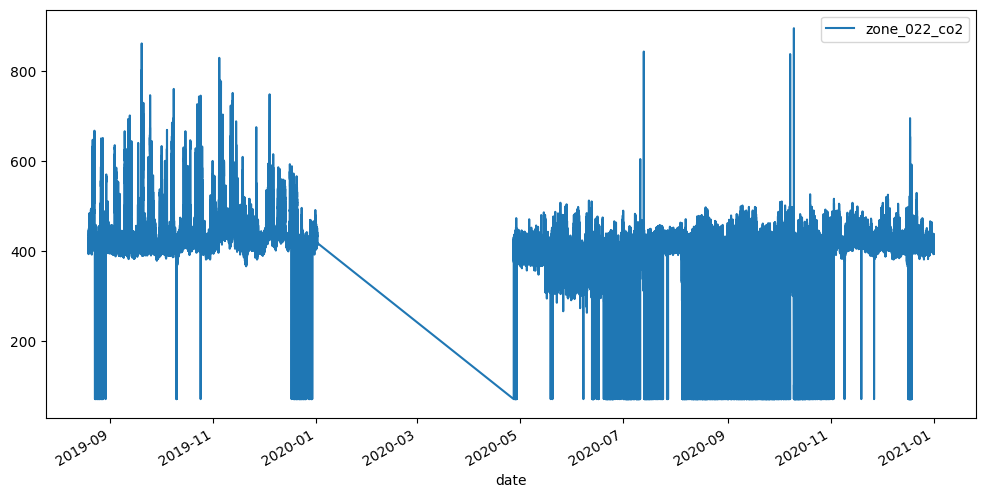

끊겨 있는 부분의 수: 1
date
2020-04-27 01:50:00   116 days 09:51:00
Name: date, dtype: timedelta64[ns]


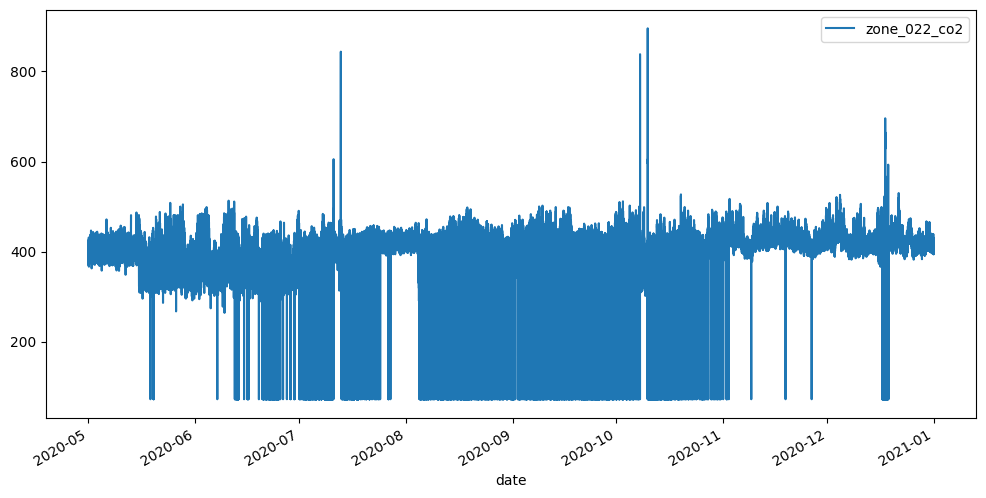

In [3]:
# CSV 파일 경로 (2020.05.01 ~ 2020.12.31 1분단위 co2 측정 )
file_path = '/content/drive/MyDrive/Colab Notebooks/data/zone_co2.csv'
column_name = 'zone_022_co2'

df = pd.read_csv(file_path, usecols=['date', column_name], index_col = 'date')
print(df.head())

df.index = pd.to_datetime(df.index)

df.plot(figsize=(12, 6))
plt.show()

# 데이터의 시간 차이 계산 (각 행과 이전 행 간의 차이)
time_diff = df.index.to_series().diff()

# 1분(60초)보다 큰 차이를 갖는 행들을 필터링하여 끊긴 부분을 찾기
gaps = time_diff[time_diff > pd.Timedelta(minutes=1)]

# 결과 출력
print(f"끊겨 있는 부분의 수: {len(gaps)}")
print(gaps)

# # 2020년 5월 1일 이후의 데이터만 필터링
df = df.loc['2020-05-01':]
df.plot(figsize=(12, 6))
plt.show()


                     zone_022_co2
date                             
2020-05-18 23:32:00          72.0
2020-05-19 21:16:00          72.0
2020-05-19 21:17:00          72.0
2020-05-19 21:18:00          72.0
2020-05-19 21:19:00          72.0
...                           ...
2020-12-18 19:19:00          72.0
2020-12-18 19:24:00          72.0
2020-12-18 19:29:00          72.0
2020-12-18 19:29:00          72.0
2020-12-18 19:38:00          72.0

[21155 rows x 1 columns]
이상치 수: 21155
이상치 비율: 5.81%


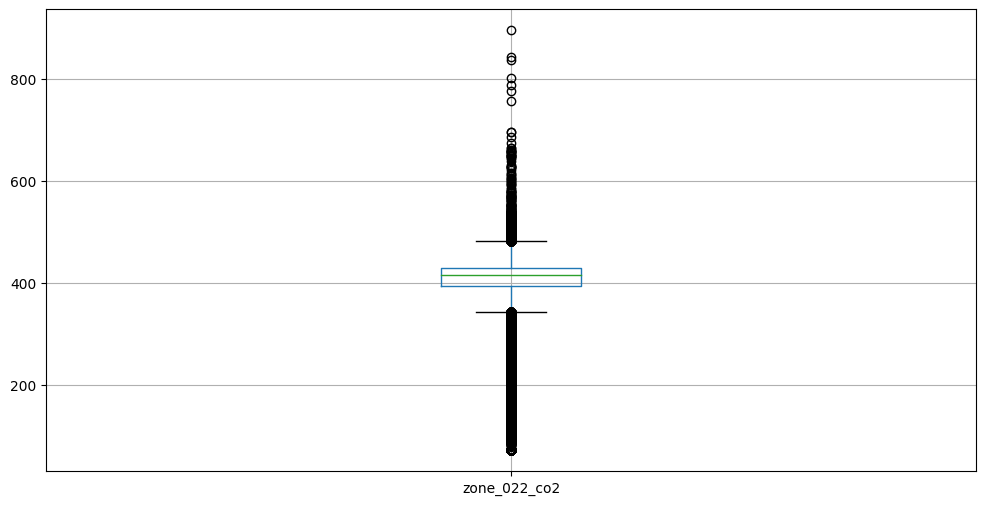

zone_022_co2    0
dtype: int64


In [4]:
outlier_detected = df[np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std()) > 3]
print(outlier_detected)
outlier_ratio = len(outlier_detected)
print(f"이상치 수: {outlier_ratio}")
print(f"이상치 비율: {round(outlier_ratio/len(df)*100,2)}%")

df.boxplot(figsize=(12, 6))
plt.show()

# 각 열의 결측치 수
print(df.isnull().sum())

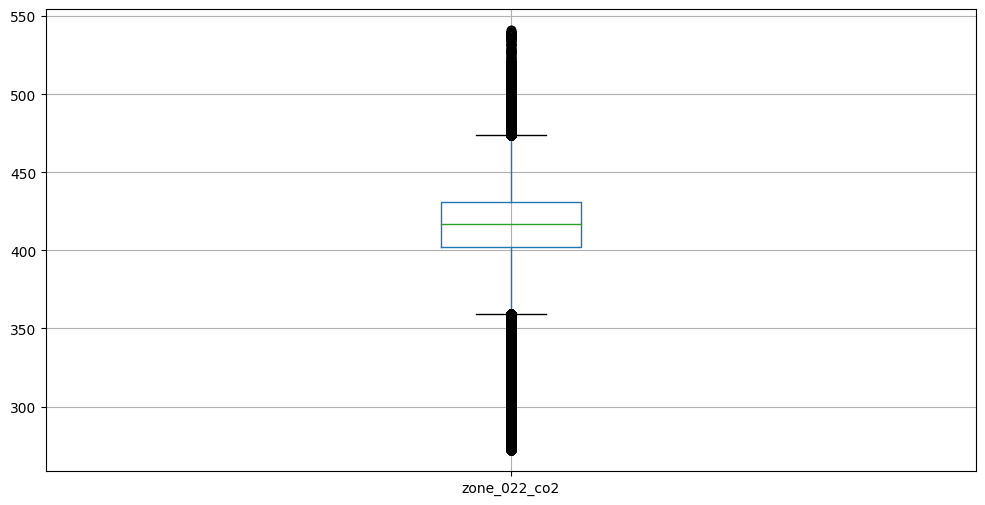

                     zone_022_co2
date                             
2020-05-15 19:54:00    308.922023
2020-05-16 04:46:00    308.165816
2020-05-16 16:59:00    295.378325
2020-05-17 21:27:00    310.301252
2020-05-18 14:26:00    308.000904
...                           ...
2020-12-21 20:38:00    516.000000
2020-12-21 20:39:00    520.000000
2020-12-21 20:48:00    514.000000
2020-12-21 21:06:00    514.000000
2020-12-21 21:07:00    515.000000

[5013 rows x 1 columns]
이상치 수: 5013
이상치 비율: 1.38%


In [19]:
# 이상치를 이전 값으로 대체
df.loc[:, column_name] = df.loc[:, column_name].mask(np.abs((df.loc[:, column_name] - df.loc[:, column_name].mean()) / df.loc[:, column_name].std()) > 3)
df.loc[:, column_name] = df.loc[:, column_name].ffill()

# 이상치가 처리된 열의 박스플롯을 시각화하여 결과를 확인합니다.
df.boxplot(column=column_name, figsize=(12, 6))
plt.show()


# 이상치 확인 (2.24 표준편차를 벗어나는 값들)
outliers_detected = df[np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std()) > 3]
print(outliers_detected)
outlier_ratio = len(outliers_detected)
print(f"이상치 수: {outlier_ratio}")
print(f"이상치 비율: {round(outlier_ratio/len(df)*100,2)}%")

In [6]:
# 데이터 로드 및 전처리 (데이터셋 나누기 전에 수행하는 것이 좋음!)
def load_data_from_csv(df, column_name):
    data = df
    data = data[column_name].values.reshape(-1, 1)

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler

data, scaler = load_data_from_csv(df, column_name)

- .values : data값을 Numpy 배열로 바꾸어줌 <br>
- .reshpae(-1,1) : 2차원 배열로 변환하여 스케일러에 적합한 형태로 만들어줌<br>
- MinMaxScaler() : 정규화 (0에서 1사이의 값으로 만들어줌)<br>
- fit_transform : 정규화 실행을 도움<br>
scaler를 return해주는 이유는 나중에 원래의 형태로 복원할 때 필요하기 때문.
(원본 데이터의 최솟값과 최댓값을 가지고 있음)


Pytorch Dataset(), DataLoader() 선언 및 데이터셋 분할(훈련/테스트)
<br>
Pytorch에서 data를 가져오고 사용할 때, Dataset(), DataLoader()를 사용하는 것을 권장한다.<br>
window_size 만큼의 데이터를 통해 다음 데이터를 예측해나간다. 시계열 데이터에서 자주 사용하는 방식이다.

In [7]:
# 데이터셋 클래스 정의
class Co2Dataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.window_size]
        y = self.data[idx+self.window_size]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

- __init__() : 데이터 및 시퀀스의 길이 정보를 저장 <br>
- __len__() : 데이터의 샘플 개수를 반환 => 배치를 나눌 때 몇 번 반복해야 할지 결정
<br>
- __getitem__() : 주어진 인덱스 idx 에 해당하는 샘플을 데이터셋에서 불러오고 반환 <br><br> __len__ 보충설명 <br>
data 가 1\~12인데, seq길이가 3이라면, 1\~3, 2\~4.... 9\~11로 총 9개이다. (10\~12로는 13의 label(정답)이 없기 때문에 예측을 수행할 수 없다.) <br>
보통 data 와 label로 구분하지만, 단순 시계열 데이터를 예측할 때에는 이전 데이터를 통해 이후 데이터를 예측하는 것을 반복해주어야 한다.

In [8]:
# 데이터셋 생성
window_size = 10
dataset = Co2Dataset(data, window_size)

# 훈련/검증 데이터 분리 (75% 훈련 데이터, 25% 테스트 데이터)
train_size = int(len(dataset) * 0.75)

# 학습과 테스트 데이터셋을 슬라이싱으로 나누기
train_dataset = Subset(dataset, list(range(train_size)))
test_dataset = Subset(dataset, list(range(train_size, len(dataset))))

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

DataLoader : 모델에 데이터셋을 작은 배치 단위로 나누어 전달해줌. <br>
데이터셋 순회, 배치 생성, 셔플링, 병렬 처리등을 지원
- Batch란?
한 번에 모델에 입력되는 데이터의 묶음<br>
데이터셋 전체를 한 번에 입력하는 것 보다 Batch로 나누어 학습하는 방법이 더 효율적임.<br>

- 실제로 모델이 한 번에 학습하는 data point = window_size * batch_size

#LSTM모델 설계

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, dropout=0.2): # LSTM 전체 모델 정의
        super(LSTMModel, self).__init__() # Moudle(부모 클래스의 생성자 호출
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # nn.LSTM을 통해 LSTM 레이어 정의
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # 출력 크기 조정 (FC레이어 = 선형 변환 레이어 정의)
        self.fc = nn.Linear(hidden_size, output_size)

        # 가중치와 편향을 초기화
        self._initialize_weights()

    def _initialize_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x): # x는 입력 데이터 (하나의 batch)
        # 초기 은닉 상태와 셀 상태 정의
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM 통과
        out, _ = self.lstm(x, (h0, c0))

        # 마지막 시퀀스의 출력만 선택하여 FC 레이어에 통과
        out = self.fc(out[:, -1, :])
        out = torch.sigmoid(out)  # 시그모이드 활성화 함수 추가

        return out

**Long Short-Temr Memory, LSTM**

<torch.nn.modules.rnn의 LSTM 모델 소스코드 분석하기><br>
- __init__() : LSTM계층 및 완전 연결층 정의를 수행<br>
- _initialize_weights() : 모델의 가중치와 편향 초기화<br>
self.lstm.named_parameters() : 모델의 파라미터들에 접근할 수 있도록 해줌.(Module의 내장 함수) <br>
nn.init.xavier_uniform_() : Xavier 초기화 (입출력의 분산이 같도록) <br>
nn.init.zeros_() : 0값으로 초기화 <br>
위는 lsmt레이어의 파라미터들에 해당, -> fc에 대해 동일한 작업 추가 수행<br>
https://pytorch.org/docs/stable/nn.init.html
<br>

- _forward() : 모델에서 실행되어야 하는 계산을 정의

#모델 학습

In [10]:
# 모델 학습 함수
def train_model(train_loader, num_epochs=5, learning_rate=0.001, device=device):
    model = LSTMModel().to(device)
    criterion = nn.MSELoss() #손실 함수
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) #최적 가중치를 찾아주는 알고리즘

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for seqs, targets in train_loader:
            seqs, targets = seqs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(seqs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    return model
print(device)

cpu


In [11]:
# 모델 학습
model = train_model(train_loader, device=device)

Epoch 1/5, Loss: 0.0027
Epoch 2/5, Loss: 0.0018
Epoch 3/5, Loss: 0.0017
Epoch 4/5, Loss: 0.0016
Epoch 5/5, Loss: 0.0016


# 예측 및 성능 평가

In [12]:
# 예측 함수
def predict(model, test_loader, scaler, device=device):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for seqs, targets in test_loader:
            seqs, targets = seqs.to(device), targets.to(device)
            outputs = model(seqs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

    return predictions, actuals

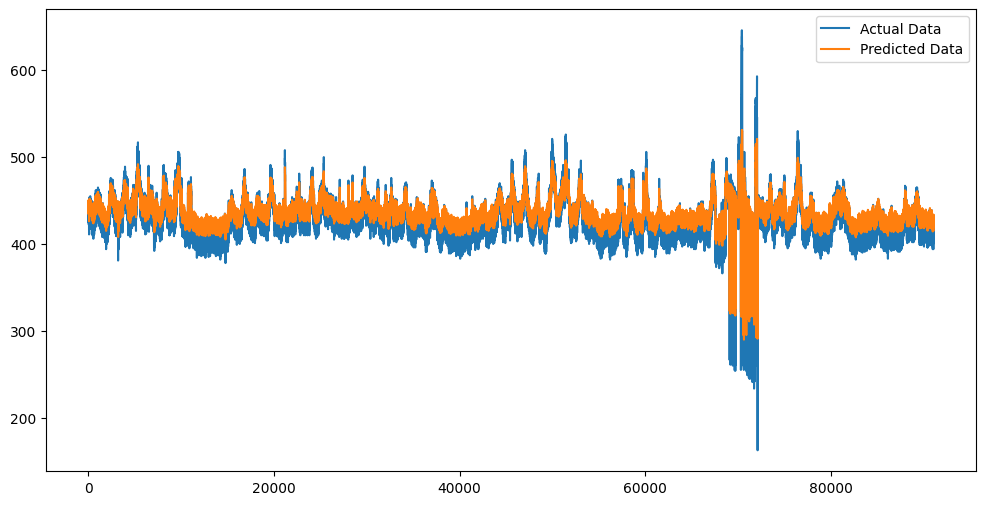

In [13]:
# 테스트 데이터로 예측 수행
predictions, actuals = predict(model, test_loader, scaler, device=device)
model= model.to(device) # device 맞춰주기

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual Data')
plt.plot(predictions, label='Predicted Data')
plt.legend()
plt.show()

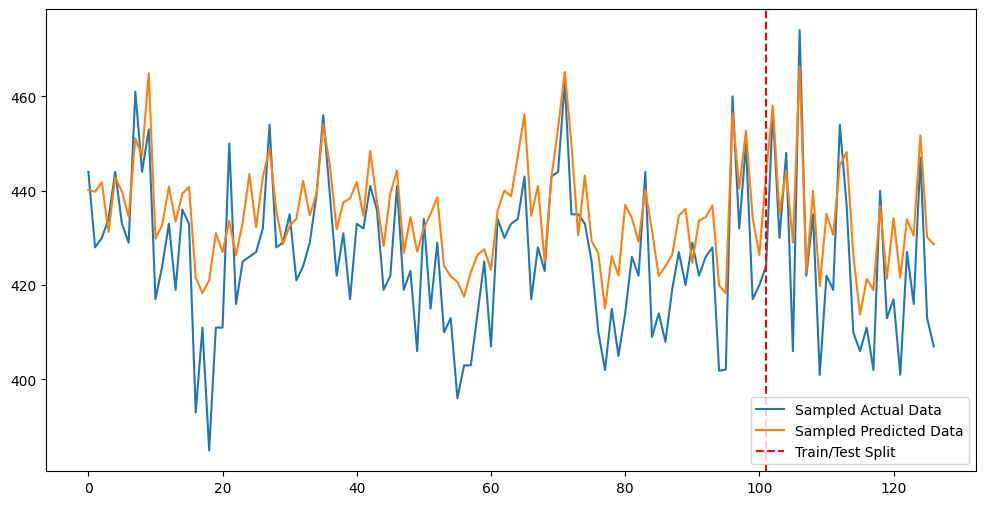

In [14]:
# 샘플링 인덱스 생성 (720개마다 하나씩, 하루에 두 개의 데이터 포인트)
sample_indices = list(range(0, len(actuals), 720))

# 샘플링된 실제 데이터와 예측 데이터
sampled_actuals = np.array(actuals)[sample_indices]
sampled_predictions = np.array(predictions)[sample_indices]

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(sampled_actuals, label='Sampled Actual Data')
plt.plot(sampled_predictions, label='Sampled Predicted Data')

# 데이터셋 분할점을 나타내는 빨간 점선 추가 (80:20 비율로 가정)
split_point = int(0.8 * len(sampled_actuals))  # 샘플링된 데이터에서의 분할점
plt.axvline(x=split_point, color='red', linestyle='--', label='Train/Test Split')

# 범례 추가 및 시각화
plt.legend()
plt.show()


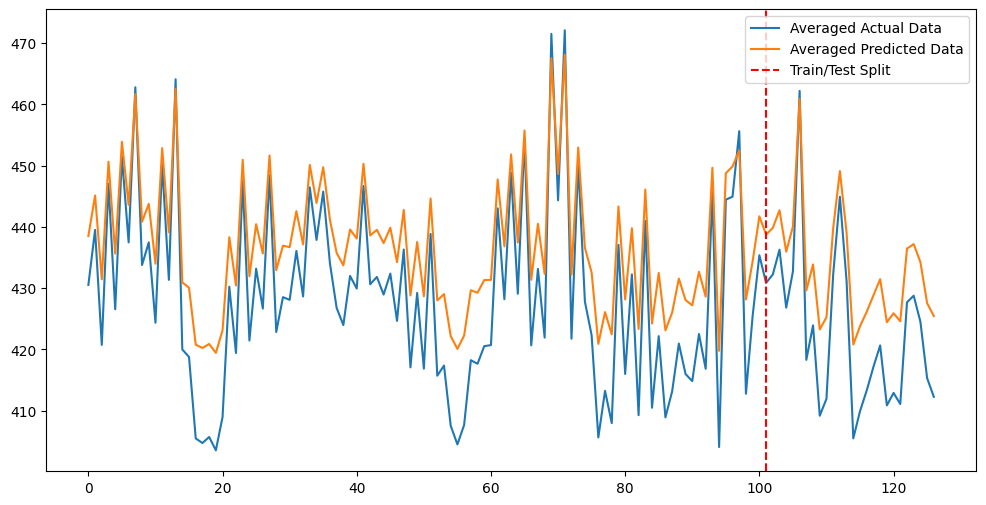

In [15]:
# 데이터를 720개씩 묶어서 평균을 계산하는 함수
def average_data(data, interval):
    # 데이터 길이를 interval로 나누어 묶음의 수를 결정
    data = np.array(data)
    averaged_data = [np.mean(data[i:i+interval]) for i in range(0, len(data), interval)]
    return averaged_data

# 720개마다 평균을 계산
interval = 720
averaged_actuals = average_data(actuals, interval)
averaged_predictions = average_data(predictions, interval)

# 시각화
plt.figure(figsize=(12, 6))
plt.plot(averaged_actuals, label='Averaged Actual Data')
plt.plot(averaged_predictions, label='Averaged Predicted Data')

# 데이터셋 분할점을 나타내는 빨간 점선 추가 (80:20 비율로 가정)
split_point = int(0.8 * len(averaged_actuals))  # 평균을 낸 데이터에서의 분할점
plt.axvline(x=split_point, color='red', linestyle='--', label='Train/Test Split')

# 범례 추가 및 시각화
plt.legend()
plt.show()


회귀문제에서는 보통 정확도를 사용하지 않음. <br>
MSE, MAE, RMSE, R^2, MAPE 등을 주로 사용

In [16]:
# 예측 결과와 실제 값 비교
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)  # RMSE는 MSE의 제곱근
mae = mean_absolute_error(actuals, predictions)

print(f"Mean Squared Error (MSE) on Test Data: {mse:.4f}")
print(f"Root Mean Squared Error (RMSE) on Test Data: {rmse:.4f}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae:.4f}")


Mean Squared Error (MSE) on Test Data: 202.8274
Root Mean Squared Error (RMSE) on Test Data: 14.2417
Mean Absolute Error (MAE) on Test Data: 10.7181


In [17]:
"""
# 모델 저장
def save_model(model, path):
    torch.save(model.state_dict(), path)

save_model(model, '/content/drive/MyDrive/Colab Notebooks/data/mylstm3.h5')
"""

"\n# 모델 저장\ndef save_model(model, path):\n    torch.save(model.state_dict(), path)\n\nsave_model(model, '/content/drive/MyDrive/Colab Notebooks/data/mylstm3.h5')\n"

In [18]:
"""
# 모델 로드
def load_model(path, device='cpu'):
    model = LSTMModel().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    return model

model = load_model('/content/drive/MyDrive/Colab Notebooks/data/lstm_seq_prediction.h5')
"""

"\n# 모델 로드\ndef load_model(path, device='cpu'):\n    model = LSTMModel().to(device)\n    model.load_state_dict(torch.load(path, map_location=device))\n    return model\n\nmodel = load_model('/content/drive/MyDrive/Colab Notebooks/data/lstm_seq_prediction.h5')\n"


- 피드백<br>
해당 LSTM모델을 ***어떻게 사용할 것인지***...!
예측해서 끝이 아니라 어떻게 이용할 수 있는지...!<br>
이상 탐지 및 제어 시스템 구축 ...!??! ❓
